In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%load_ext autoreload
%autoreload 2

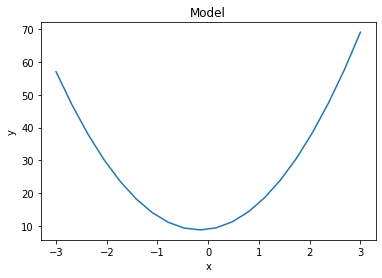

In [2]:
def arbitrary_poly(params):
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model

# params: [theta_0, theta_1, ... , theta_n], where n = model order and theta_0 is bias
true_params = [9, 2, 6]
y_model = arbitrary_poly(true_params)

# Plot true model
x = np.linspace(start=-3, stop=3, num=20)
y = y_model(x)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Model");

### 2.1  
Consider the same situation of tasks 1.1 and 1.2 in assignment 1, but with the additional possibility of ‘faulty measurements’ in the following sense: with a probability $\gamma$ the sensor returns something meaningless, i.e., with probability $\gamma$ $e_t$ is so that $y_t = 100$. With probability $1 - \gamma$, instead, the sensor works fine and thus the same probabilistic model for generating $e_t$ applies. Note: the outlier events are i.i.d., i.e., the fact that one has an outlier at time $t$ does not modify the probability of having an outlier also at time $t+1$ 

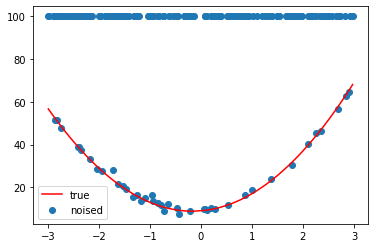

In [3]:
# Clean model
N = 201

# Generate data points
range_low = -3
range_high = 3
u = np.sort(np.random.uniform(range_low, range_high, N))
y = y_model(u)

# Noise parameters
gamma = 0.8
laplace_var = 1
laplace_mean = 0
magnitude = 1

def noisify(y, gamma, laplace_mean, laplace_var, magnitude):
    y_noised = y.copy()
    for i in range(len(y)):
        if np.random.binomial(1, gamma):
            y_noised[i] = 100
        else:
            laplace_sample = magnitude * np.random.laplace(laplace_mean, laplace_var, 1)
            y_noised[i] += laplace_sample
    return y_noised

y_noised = noisify(y, gamma, laplace_mean, laplace_var, magnitude)
plt.scatter(u, y_noised, label='noised')
plt.plot(u, y, label='true', color='r')
plt.legend()
plt.show()

### 2.2  
With respect to assignment 1, though, modify the $u_t$'s so to be \textbf{201} uniformly spaced values in $[-3, 3]$, and set $\alpha = 0$ so that we have Laplacian noises (more precisely, with scale $\beta = 1$). Keep the "true model" quadratic.

In [4]:
def compute_u_tensor(u, n_params):
    # Matrix form
    N = len(u)
    u_tensor_0 = np.reshape(u, (N, 1))
    ones_vec = np.ones((N, 1))
    u_tensor = np.append(ones_vec, u_tensor_0, axis=1)
    for i in range(2, n_params):
        u_tensor = np.append(u_tensor, np.power(u_tensor_0, i), axis=1)
    return u_tensor


def LS_estimate_params(u_tensor, y):
    theta_hat = np.linalg.inv(u_tensor.T @ u_tensor) @ u_tensor.T @ y
    return theta_hat


u_tensor = compute_u_tensor(u, n_params=len(true_params))
print(f"data u :\n{u_tensor[:5]} \n")
print(f"data tensor [1, u, u^2, ... , u^n] :\n{u_tensor[0:5,:]}")

theta_hat = LS_estimate_params(u_tensor, y_noised)
LS_params_rounded = ["{:.2f}".format(round(i, 2)) for i in theta_hat.tolist()]
print(f"LS parameters:         {LS_params_rounded}")
print(f"True model parameters: {true_params}")

data u :
[[ 1.         -2.99019904  8.94129029]
 [ 1.         -2.98069234  8.88452683]
 [ 1.         -2.89173321  8.36212098]
 [ 1.         -2.86303807  8.19698697]
 [ 1.         -2.85941925  8.17627842]] 

data tensor [1, u, u^2, ... , u^n] :
[[ 1.         -2.99019904  8.94129029]
 [ 1.         -2.98069234  8.88452683]
 [ 1.         -2.89173321  8.36212098]
 [ 1.         -2.86303807  8.19698697]
 [ 1.         -2.85941925  8.17627842]]
LS parameters:         ['78.86', '1.71', '1.89']
True model parameters: [9, 2, 6]


#### Plotting LS estimate of noisy data

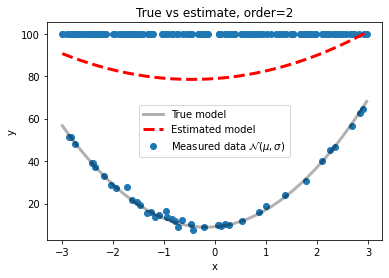

In [5]:
# Recreate model based on LS estimate:
LS_params = theta_hat.tolist()
LS_estimate = arbitrary_poly(theta_hat) # func
u0 = np.linspace(min(u), max(u), N)
estimate = LS_estimate(u0)

def plot_true_vs_estimated(u, y_noised, estimate, order, y=None):
    """Plot true vs. estimated model"""
    plt.scatter(u, y_noised, label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
    u0 = np.linspace(min(u), max(u), len(estimate)) # redundant calc of x-linspace
    if type(y) != type(None):
        plt.plot(u, y, "k", alpha=0.3, lw=3, label="True model")
    plt.plot(u0, estimate, "r--",  lw=3, label="Estimated model")
    plt.legend()
    plt.title(f'True vs estimate, order={order}')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    
plot_true_vs_estimated(u, y_noised, estimate, order=len(theta_hat)-1, y=y)

### 2.3

$\widehat{	heta}$ = [84.70756441  1.65408203]


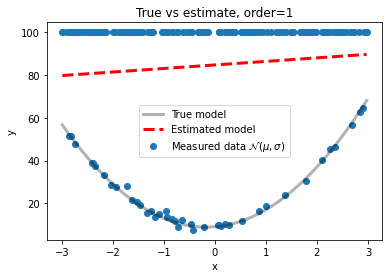

$\widehat{	heta}$ = [78.85647024  1.71470175  1.89046379]


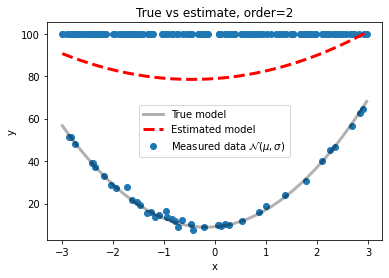

$\widehat{	heta}$ = [79.39643798  5.63755196  1.77797598 -0.73320023]


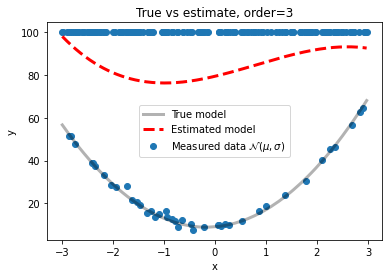

In [6]:
for order in range(1, 4):
    u_tensor = compute_u_tensor(u, n_params=order+1)
    u0 = np.linspace(min(u), max(u), N)
    theta_hat = LS_estimate_params(u_tensor, y_noised)
    print('$\widehat{\theta}$ =', theta_hat)
    LS_estimate = arbitrary_poly(theta_hat) # func
    plot_true_vs_estimated(u, y_noised, LS_estimate(u0), order=len(theta_hat)-1, y=y)

### 2.4  
Code the full "model order selection / parameters estimation / predictions performance estimation" paradigm by considering the first third of the dataset as a training set, the second as a test set, and the third as a validation set. As "prediction performance index" consider the sum of the absolute deviations between the actually measured $y_t$'s and the predicted ones $\widehat{y}_t$ (i.e., $\widehat{y}_t = \left[ \widehat{\theta}_0, \widehat{\theta}_1, \widehat{\theta}_2, \ldots \right] \left[ 1, u_t, u_t^2, \ldots \right]^T$ with the $\widehat{\theta}$'s the estimated parameters corresponding to the selected model order). Use the same performance index to solve also the model order selection problem 

In [7]:
import pandas as pd

train_frac = 0.6
test_frac = 0.2

# u, y to dataframe
xy_df = pd.DataFrame(u_tensor).sort_index()
xy_df['y_noised'] = y_noised

def split_train_test_validate(df, train_frac, test_vali_frac):
    """Split into sets with shuffling"""
    train, test, validate = np.split(
        df.sample(frac=1), 
        [int(train_frac*len(df)), int((1 - test_vali_frac)*len(df))]
    )
    return train.sort_index(), test.sort_index(), validate.sort_index()

train, test, validate = split_train_test_validate(xy_df, train_frac, test_frac)

#### Plot splitted data sets

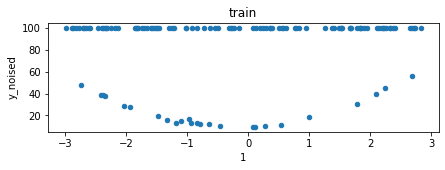

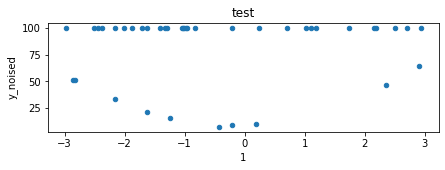

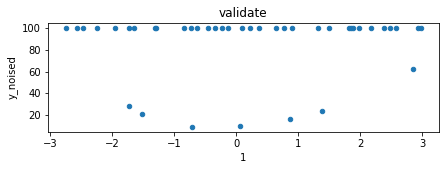

In [8]:
train.plot(kind='scatter', x=1, y='y_noised', title='train', figsize=(7, 2));
test.plot(kind='scatter', x=1, y='y_noised', title='test', figsize=(7, 2));
validate.plot(kind='scatter', x=1, y='y_noised', title='validate', figsize=(7, 2));

In [9]:
import scipy.optimize as optimize
from scipy.stats import norm, laplace
pdf = norm.pdf


def log_lik(par_vec, y, x):
    global pdf
    # If the standard deviation parameter is negative, return a large value:
    if par_vec[-1] < 0:
        return(1e8)
    # The likelihood function values:
    loc = sum([p*(x**i) for i, p in enumerate(par_vec[:-1])]),
    lik = pdf(y, loc=loc, scale=par_vec[-1])
    # If all logarithms are zero, return a large value
    if all(v == 0 for v in lik[0]):
        return(1e8)
    # Logarithm of zero = -Inf
    return -np.sum(np.log(lik[np.nonzero(lik)]))


def MLE_y_hat(u, y, order):
    # The likelihood function includes the scale (std dev) parameter which is also estimated by the optimized
    # therefore the initial guess vector has length n+2 [theta_0_hat, theta_1_hat, ... , theta_n_hat, sigma_hat]
    init_guess = np.zeros(order + 2)
    init_guess[-1] = len(u) # N

    # Do Maximum Likelihood Estimation:
    opt_res = optimize.minimize(
        fun=log_lik,
        x0=init_guess,
        options={'disp': True},
        args=(y, u)
    )
    MLE_params = opt_res.x[:-1]
    y_hat = arbitrary_poly(MLE_params)
    return MLE_params, y_hat

In [10]:
assert np.all(pd.concat([train, test, validate]).sort_index() == xy_df)


def sum_abs_dev(y, y_hat):
    """Model loss"""
    return np.sum(np.abs(y - y_hat))


def poly_y_hat(xy_df, theta_hat=None):
    if theta_hat is None:
        u = xy_df.loc[:, xy_df.columns != 'y_noised']
        y = xy_df["y_noised"]
        theta_hat = LS_estimate_params(u, y)
    estimate = arbitrary_poly(theta_hat) # func
    u0 = np.linspace(xy_df[1].min(), xy_df[1].max(), len(xy_df.index))
    y_hat = estimate(u0)
    return theta_hat, y_hat


def slugify_theta(theta):
    return ','.join(map(str, theta))


def deslugify_theta(theta_str):
    return list(map(float, theta_str.split(',')))

#### Model order selection

LS:


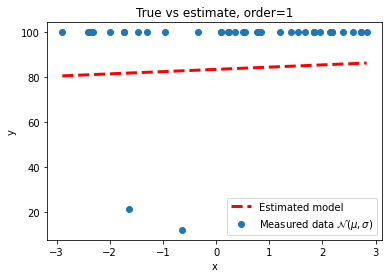

MLE:
Optimization terminated successfully.
         Current function value: 583.400502
         Iterations: 15
         Function evaluations: 120
         Gradient evaluations: 30


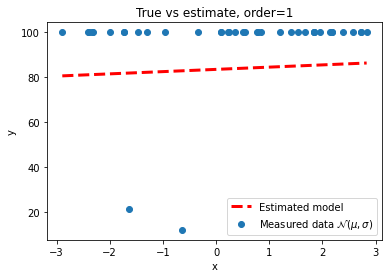

LS:


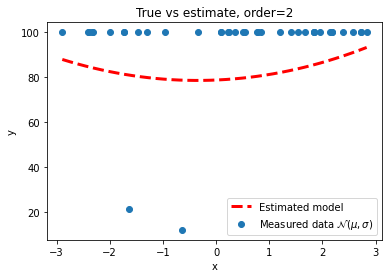

MLE:
         Current function value: 582.430063
         Iterations: 22
         Function evaluations: 165
         Gradient evaluations: 33


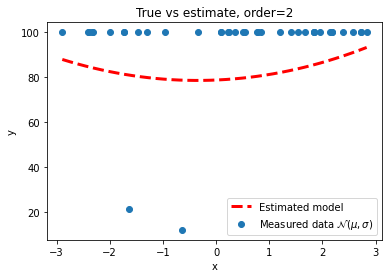

LS:


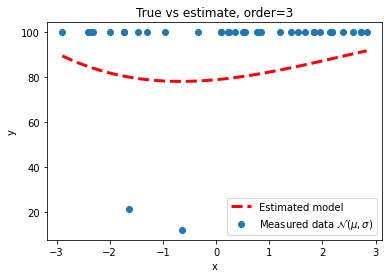

MLE:
Optimization terminated successfully.
         Current function value: 582.382980
         Iterations: 29
         Function evaluations: 204
         Gradient evaluations: 34


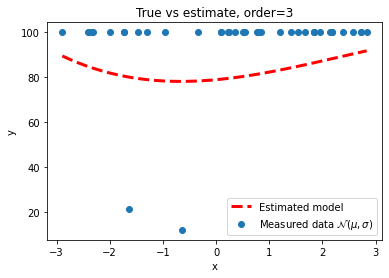

In [16]:
# Generate data
cubic_order = 3
u_tensor = compute_u_tensor(u, n_params=cubic_order+1)
xy_df = pd.DataFrame(u_tensor).sort_index() # to df
xy_df['y_noised'] = y_noised
train, test, validate = split_train_test_validate(xy_df, train_frac, test_frac)

# Init model performance df
orders = list(range(1, cubic_order+1))
model_perfs = pd.DataFrame(
    index=orders, 
    columns=['theta_LS', 'theta_MLE', 'loss_LS', 'loss_MLE']
)
model_perfs.index.name = 'order'

for order in orders:
    # Only choose columns of data up to order
    allowed_cols = ['y_noised']
    allowed_cols.extend(list(range(0, order+1)))
    
    # Least squares estimates
    print('LS:')
    theta, y_hat = poly_y_hat(train.loc[:, allowed_cols])
    _, y_hat_test = poly_y_hat(test.loc[:, allowed_cols], theta_hat=theta)
    plot_true_vs_estimated(test.loc[:, 1], test.loc[:, 'y_noised'], y_hat_test, order=order)
    
    # MLE estimates
    print('MLE:')
    MLE_params, MLE_estimate = MLE_y_hat(train.loc[:, 1], train.loc[:, 'y_noised'], order=order)
    _, MLE_test = poly_y_hat(test.loc[:, allowed_cols], theta_hat=MLE_params)
    plot_true_vs_estimated(test.loc[:, 1], test.loc[:, 'y_noised'], MLE_test, order=order)
    
    # Add performance and params for LS
    model_perfs.loc[order, 'theta_LS'] = slugify_theta(theta)
    model_perfs.loc[order, 'theta_MLE'] = slugify_theta(MLE_params)
    model_perfs.loc[order, 'loss_LS'] = sum_abs_dev(test['y_noised'], y_hat_test)
    model_perfs.loc[order, 'loss_MLE'] = sum_abs_dev(test['y_noised'], MLE_test)
    
    
model_perfs['loss_LS'] = pd.to_numeric(model_perfs['loss_LS'])
model_perfs['loss_MLE'] = pd.to_numeric(model_perfs['loss_MLE'])
argmin_LS = model_perfs['loss_LS'].idxmin() # Estimated model order
argmin_MLE = model_perfs['loss_MLE'].idxmin() # Estimated model order
best_theta_LS = deslugify_theta(model_perfs.loc[argmin_LS, 'theta_LS'])
best_theta_MLE = deslugify_theta(model_perfs.loc[argmin_MLE, 'theta_MLE'])

# ?

In [12]:
best_theta_LS, argmin_LS # Params and order

([83.92011789977686, 1.2711739598160972], 1)

In [14]:
best_theta_MLE, argmin_MLE # Params and order

([83.92011361833922, 1.2711602163656082], 1)

In [15]:
model_perfs

,theta_LS,theta_MLE,loss_LS,loss_MLE
order,,,,
1,"83.92011789977686,1.2711739598160972","83.92011361833922,1.2711602163656082",864.412520,864.412606
2,"76.02743996444484,1.334856163969106,2.43148050...","76.02724948444732,1.3348525376672513,2.4315178...",908.849802,908.852412
3,"76.5823651544384,5.141427557024082,2.300087580...","76.58230246235557,5.14141320252302,2.300099163...",892.864546,892.865465


### 2.5  
Create some plots that motivate your model order choice, and comment how this choice is easier / more difficult depending on different values of the outliers probability $\gamma$, and which differences you see between the LS and ML solutions